<a href="https://colab.research.google.com/github/Ankit-LASA/Data-Science/blob/main/AnkiBhasU8proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
!pip install preliz

In [4]:
import preliz as pz

In [3]:
!pip install pymc-bart

In [5]:
import pymc_bart as pmb

# Unit 8 Project: Height

## Introduction

## Model

In [6]:
#import
#drop the incomplete rows from the data
url = "https://raw.githubusercontent.com/Ankit-LASA/Data-Science/refs/heads/main/stature_hand_foot.csv"
bodyType = pd.read_csv(url).dropna()

In [ ]:
bodyType

,idGen,gender,height,handLen,footLen
0,1,1,1829.356,205.7455,294.1762
1,2,1,1730.262,197.5946,283.2275
2,3,1,1723.990,193.6019,238.9127
3,4,1,1748.885,224.5994,289.4070
4,5,1,1697.573,200.8021,247.0631
...,...,...,...,...,...
150,71,2,1546.848,182.3627,222.5443
151,72,2,1602.703,188.1426,235.4272
152,73,2,1671.917,189.6964,250.4256
153,74,2,1625.468,188.1226,228.7377


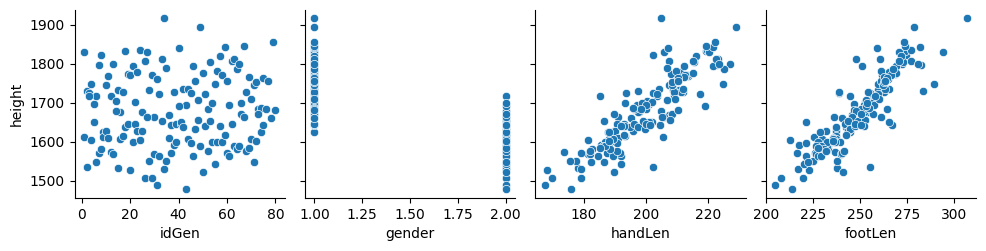

In [7]:
sns.pairplot(bodyType, y_vars=['height'], x_vars=bodyType.columns.drop('height'), kind='scatter')

In [8]:
#features = ['gender', 'handLen', 'footLen']]
#need to combine multiple into one
X = bodyType[['gender', 'handLen', 'footLen']]
#copy from code
Y = bodyType['height'].to_numpy()

In [9]:
#this is mostly just copied from the code, but the likelihood is changed
#the reason why I'm using normal was done above on the histogram
with pm.Model() as model_BART:
    s = pm.HalfNormal('s',20) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_BART = pm.sample(compute_convergence_checks=False)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.86        3            32.52 draws/s    0:01:01   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             1.17        1            16.11 draws/s    0:02:04   0:00:00

In [10]:
#copy
pm.sample_posterior_predictive(idata_BART,model_BART, extend_inferencedata=True)

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

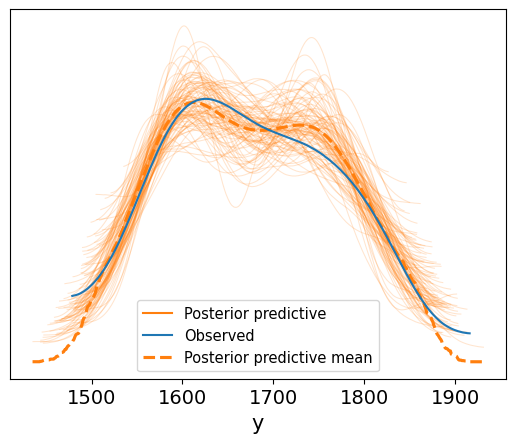

In [11]:
ax = az.plot_ppc(idata_BART, num_pp_samples=100, colors=["C1", "C0", "C1"])

This data looks incredibly accurate for my first model. The poster predictive strongly matches the obersved data.

In [12]:
#all of this is practically copied
posterior_mean = idata_BART.posterior["μ"]

μ_hdi = az.hdi(ary=idata_BART, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_BART, group="posterior_predictive", var_names=["y"]
).T

In [ ]:
idx = np.argsort(X.to_numpy()[:, 2]) #grab fifth row
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:, 2],#grab fifth row
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:, 2],#grab fifth row
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(penguins_nona['flipper_length'], penguins_nona["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

## Conclusion